In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Try to import fasttext
try:
    import fasttext
    print(f"FastText version: {fasttext.__version__}")
    FASTTEXT_AVAILABLE = True
except ImportError:
    print("FastText not installed. Will use gensim's FastText implementation.")
    from gensim.models import FastText
    print(f"Using Gensim FastText")
    FASTTEXT_AVAILABLE = False

Libraries imported successfully!
FastText not installed. Will use gensim's FastText implementation.
Using Gensim FastText


In [2]:
# Load the data
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (104, 5)

First few rows:


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources prof...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,NaN


## FastText Ranking System

FastText is particularly good for:
- **Typos and Misspellings**: Can handle variations like "managr" vs "manager"
- **Rare Words**: Generates embeddings even for words not in training data
- **Morphological Variations**: Understands relationships between "manage", "manager", "management"

In [3]:
class FastTextRankingSystem:
    """
    A ranking system using FastText embeddings for semantic matching.
    """
    
    def __init__(self, keywords, use_connections=True, vector_size=100, window=5, min_count=1):
        """
        Initialize the FastText ranking system.
        
        Parameters:
        -----------
        keywords : str or list
            Target role keywords to match against
        use_connections : bool
            Whether to factor in number of connections
        vector_size : int
            Dimensionality of word vectors
        window : int
            Maximum distance between current and predicted word
        min_count : int
            Ignores words with total frequency lower than this
        """
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None
        self.starred_candidates = []
        self.ranking_history = []
        
    def preprocess_text(self, text):
        """Clean and preprocess text data."""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def tokenize(self, text):
        """Tokenize text into words."""
        from gensim.utils import simple_preprocess
        return simple_preprocess(self.preprocess_text(text), deacc=True)
    
    def normalize_connections(self, connections_series):
        """Normalize connection counts to 0-1 scale."""
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def get_document_vector(self, tokens):
        """
        Get document vector by averaging word vectors.
        FastText can generate vectors even for out-of-vocabulary words!
        """
        vectors = []
        for token in tokens:
            # FastText can always generate a vector, even for OOV words
            try:
                vectors.append(self.model.wv[token])
            except KeyError:
                # Shouldn't happen with FastText, but handle gracefully
                pass
        
        if len(vectors) == 0:
            return np.zeros(self.vector_size)
        
        return np.mean(vectors, axis=0)
    
    def train_fasttext(self, df):
        """Train FastText model on all job titles."""
        from gensim.models import FastText as GensimFastText
        
        # Tokenize all job titles
        tokenized_titles = df['job_title'].apply(self.tokenize).tolist()
        
        # Add keywords to training corpus
        tokenized_keywords = [self.tokenize(self.keywords)]
        all_documents = tokenized_keywords + tokenized_titles
        
        # Train FastText model
        # min_n and max_n control character n-gram range (3-6 is typical)
        self.model = GensimFastText(
            sentences=all_documents,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=4,
            epochs=100,
            sg=1,  # Use skip-gram
            min_n=3,  # Min character n-gram length
            max_n=6   # Max character n-gram length
        )
        
        print(f"FastText model trained with {len(self.model.wv)} words")
        print(f"Using character n-grams from {self.model.wv.min_n} to {self.model.wv.max_n}")
        
    def calculate_initial_fit(self, df):
        """Calculate initial fitness scores using FastText embeddings."""
        # Train FastText model
        self.train_fasttext(df)
        
        # Get keyword vector
        keyword_tokens = self.tokenize(self.keywords)
        keyword_vector = self.get_document_vector(keyword_tokens).reshape(1, -1)
        
        # Get vectors for all job titles
        job_vectors = []
        for title in df['job_title']:
            tokens = self.tokenize(title)
            vector = self.get_document_vector(tokens)
            job_vectors.append(vector)
        
        job_vectors = np.array(job_vectors)
        
        # Calculate cosine similarity
        similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        # Factor in connections if enabled
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def calculate_fit_with_feedback(self, df, starred_indices):
        """Recalculate fitness incorporating starred candidates."""
        # Get keyword vector
        keyword_tokens = self.tokenize(self.keywords)
        keyword_vector = self.get_document_vector(keyword_tokens).reshape(1, -1)
        
        # Get vectors for all job titles
        job_vectors = []
        for title in df['job_title']:
            tokens = self.tokenize(title)
            vector = self.get_document_vector(tokens)
            job_vectors.append(vector)
        
        job_vectors = np.array(job_vectors)
        
        # Base similarity to keywords
        keyword_similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        if len(starred_indices) > 0:
            # Calculate similarity to starred candidates
            starred_vectors = job_vectors[starred_indices]
            starred_similarities = cosine_similarity(job_vectors, starred_vectors)
            max_starred_sim = starred_similarities.max(axis=1)
            
            # Combine scores
            weight_starred = min(0.6, 0.3 + (len(starred_indices) * 0.05))
            weight_keyword = 1 - weight_starred
            
            combined_scores = (weight_keyword * keyword_similarities + 
                             weight_starred * max_starred_sim)
        else:
            combined_scores = keyword_similarities
        
        # Factor in connections
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.85 * combined_scores + 0.15 * connection_scores
        else:
            final_scores = combined_scores
        
        return final_scores
    
    def rank_candidates(self, df, starred_indices=None):
        """Rank candidates and return sorted dataframe."""
        df_copy = df.copy()
        
        if starred_indices is None or len(starred_indices) == 0:
            fit_scores = self.calculate_initial_fit(df_copy)
        else:
            fit_scores = self.calculate_fit_with_feedback(df_copy, starred_indices)
        
        df_copy['fit_fasttext'] = fit_scores
        df_copy = df_copy.sort_values('fit_fasttext', ascending=False).reset_index(drop=True)
        df_copy['rank'] = range(1, len(df_copy) + 1)
        
        self.ranking_history.append(df_copy[['id', 'rank', 'fit_fasttext']].copy())
        
        return df_copy
    
    def star_candidate(self, df, candidate_rank):
        """Star a candidate and re-rank."""
        candidate_idx = df.index[df['rank'] == candidate_rank].tolist()[0]
        
        if candidate_idx not in self.starred_candidates:
            self.starred_candidates.append(candidate_idx)
            print(f"✭ Starred: {df.loc[candidate_idx, 'job_title']}")
        
        return self.rank_candidates(df, self.starred_candidates)
    
    def demonstrate_subword_capability(self, words):
        """
        Demonstrate FastText's ability to handle unknown/misspelled words.
        """
        print("\nFastText Subword Capability Demo:")
        print("="*80)
        for word in words:
            try:
                vec = self.model.wv[word]
                print(f"✓ '{word}': Vector generated (norm: {np.linalg.norm(vec):.4f})")
                
                # Find similar words
                try:
                    similar = self.model.wv.most_similar(word, topn=3)
                    print(f"  Similar: {', '.join([f'{w}({s:.3f})' for w, s in similar])}")
                except:
                    pass
            except KeyError:
                print(f"✗ '{word}': No vector available")
        print("="*80)

print("FastTextRankingSystem class defined successfully!")

FastTextRankingSystem class defined successfully!


In [4]:
# Initialize FastText ranking system
keywords = "aspiring human resources seeking human resources"
fasttext_system = FastTextRankingSystem(keywords, use_connections=True, vector_size=100)

print(f"FastText system initialized with keywords: '{keywords}'")

FastText system initialized with keywords: 'aspiring human resources seeking human resources'


In [5]:
# Rank candidates using FastText
ranked_fasttext = fasttext_system.rank_candidates(df)

print("FastText Ranking Complete!")
print(f"\nTop 15 Candidates (FastText):")
print("="*100)
ranked_fasttext[['rank', 'job_title', 'location', 'connection', 'fit_fasttext']].head(15)

FastText model trained with 194 words
Using character n-grams from 3 to 6
FastText Ranking Complete!

Top 15 Candidates (FastText):


,rank,job_title,location,connection,fit_fasttext
0,1,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.994466
1,2,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.994466
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.994466
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.994466
4,5,"Human Resources, Staffing and Recruiting Professional","Jackson, Mississippi Area",500+,0.994376
5,6,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.994159
6,7,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.994159
7,8,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,0.978714
8,9,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,0.977587
9,10,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area",500+,0.968677


## Demonstrate FastText's Subword Capability

FastText's key advantage is handling unknown words and variations.

In [6]:
# Demonstrate FastText's ability to handle variations and unknown words
test_words = [
    'resources',      # Known word
    'resource',       # Variation
    'resourceful',    # Morphological variation
    'hr',            # Known abbreviation
    'humanresources', # Compound (might be unknown)
    'recruiter',     # Related term
    'recruiting',    # Variation
]

fasttext_system.demonstrate_subword_capability(test_words)


FastText Subword Capability Demo:
✓ 'resources': Vector generated (norm: 1.4119)
  Similar: human(0.997), professional(0.990), and(0.989)
✓ 'resource': Vector generated (norm: 1.2831)
  Similar: resources(0.999), human(0.994), generalist(0.990)
✓ 'resourceful': Vector generated (norm: 0.7947)
  Similar: resources(1.000), human(0.998), and(0.991)
✓ 'hr': Vector generated (norm: 0.8415)
  Similar: office(0.983), marketing(0.981), energy(0.980)
✓ 'humanresources': Vector generated (norm: 0.9497)
  Similar: human(0.999), resources(0.995), and(0.992)
✓ 'recruiter': Vector generated (norm: 1.6808)
  Similar: international(0.998), research(0.997), louis(0.996)
✓ 'recruiting': Vector generated (norm: 1.2517)
  Similar: logging(0.994), helping(0.992), staffing(0.989)


## Compare with TF-IDF Baseline

In [7]:
# Create TF-IDF baseline for comparison
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFRankingSystem:
    """Baseline TF-IDF system for comparison."""
    
    def __init__(self, keywords, use_connections=True):
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.vectorizer = TfidfVectorizer(
            stop_words='english',
            ngram_range=(1, 3),
            min_df=1,
            lowercase=True
        )
    
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def normalize_connections(self, connections_series):
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def calculate_initial_fit(self, df):
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        all_texts = [self.keywords] + df['processed_title'].tolist()
        tfidf_matrix = self.vectorizer.fit_transform(all_texts)
        
        keyword_vector = tfidf_matrix[0:1]
        candidate_vectors = tfidf_matrix[1:]
        
        similarities = cosine_similarity(keyword_vector, candidate_vectors).flatten()
        
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def rank_candidates(self, df):
        df_copy = df.copy()
        fit_scores = self.calculate_initial_fit(df_copy)
        df_copy['fit_tfidf'] = fit_scores
        df_copy = df_copy.sort_values('fit_tfidf', ascending=False).reset_index(drop=True)
        return df_copy

# Create TF-IDF baseline
tfidf_system = TFIDFRankingSystem(keywords, use_connections=True)
ranked_tfidf = tfidf_system.rank_candidates(df)

print("TF-IDF baseline created for comparison")

TF-IDF baseline created for comparison


In [8]:
# Merge results for comparison
comparison_df = ranked_fasttext[['id', 'job_title', 'location', 'connection', 'rank', 'fit_fasttext']].copy()
comparison_df = comparison_df.rename(columns={'rank': 'rank_fasttext'})

tfidf_ranks = ranked_tfidf[['id', 'fit_tfidf']].copy()
tfidf_ranks['rank_tfidf'] = range(1, len(tfidf_ranks) + 1)

comparison_df = comparison_df.merge(tfidf_ranks, on='id', how='left')
comparison_df['rank_difference'] = comparison_df['rank_tfidf'] - comparison_df['rank_fasttext']

print("Top 20 Candidates - FastText vs TF-IDF Comparison:")
print("="*120)
comparison_df[['rank_fasttext', 'rank_tfidf', 'rank_difference', 'job_title', 
               'fit_fasttext', 'fit_tfidf']].head(20)

Top 20 Candidates - FastText vs TF-IDF Comparison:


,rank_fasttext,rank_tfidf,rank_difference,job_title,fit_fasttext,fit_tfidf
0,1,3,2,Seeking Human Resources HRIS and Generalist Positions,0.994466,0.416951
1,2,4,2,Seeking Human Resources HRIS and Generalist Positions,0.994466,0.416951
2,3,5,2,Seeking Human Resources HRIS and Generalist Positions,0.994466,0.416951
3,4,6,2,Seeking Human Resources HRIS and Generalist Positions,0.994466,0.416951
4,5,27,22,"Human Resources, Staffing and Recruiting Professional",0.994376,0.264212
5,6,8,2,Aspiring Human Resources Management student seeking an internship,0.994159,0.352899
6,7,7,0,Aspiring Human Resources Management student seeking an internship,0.994159,0.352899
7,8,21,13,Human Resources Generalist at Schwan's,0.978714,0.287764
8,9,19,10,Human Resources Generalist at Loparex,0.977587,0.287764
9,10,20,10,"Human Resources Generalist at ScottMadden, Inc.",0.968677,0.287764


## Visualization: FastText vs TF-IDF

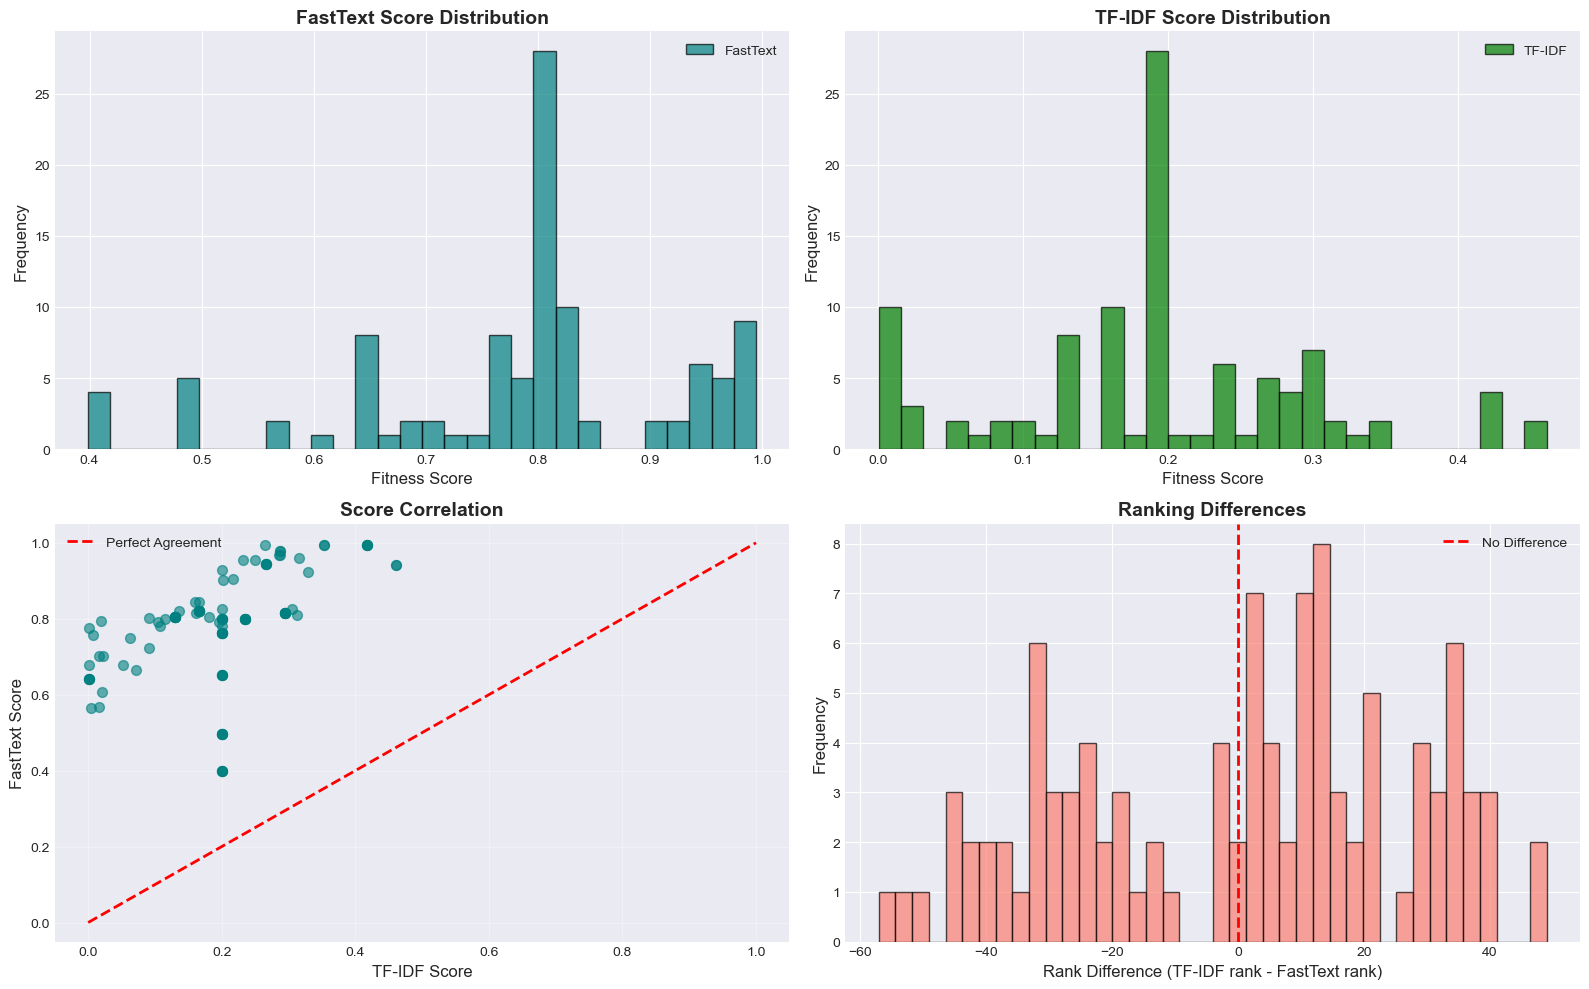


Correlation between FastText and TF-IDF scores: 0.5219


In [9]:
# Score distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograms
axes[0, 0].hist(comparison_df['fit_fasttext'], bins=30, alpha=0.7, label='FastText', color='teal', edgecolor='black')
axes[0, 0].set_xlabel('Fitness Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('FastText Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()

axes[0, 1].hist(comparison_df['fit_tfidf'], bins=30, alpha=0.7, label='TF-IDF', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Fitness Score', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('TF-IDF Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# Scatter plot: FastText vs TF-IDF scores
axes[1, 0].scatter(comparison_df['fit_tfidf'], comparison_df['fit_fasttext'], alpha=0.6, s=50, color='teal')
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
axes[1, 0].set_xlabel('TF-IDF Score', fontsize=12)
axes[1, 0].set_ylabel('FastText Score', fontsize=12)
axes[1, 0].set_title('Score Correlation', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Rank difference distribution
axes[1, 1].hist(comparison_df['rank_difference'], bins=40, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
axes[1, 1].set_xlabel('Rank Difference (TF-IDF rank - FastText rank)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Ranking Differences', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = comparison_df['fit_fasttext'].corr(comparison_df['fit_tfidf'])
print(f"\nCorrelation between FastText and TF-IDF scores: {correlation:.4f}")

In [10]:
# Statistical comparison
print("Statistical Comparison:")
print("="*80)
print(f"\nFastText Scores:")
print(f"  Mean: {comparison_df['fit_fasttext'].mean():.4f}")
print(f"  Std:  {comparison_df['fit_fasttext'].std():.4f}")
print(f"  Min:  {comparison_df['fit_fasttext'].min():.4f}")
print(f"  Max:  {comparison_df['fit_fasttext'].max():.4f}")

print(f"\nTF-IDF Scores:")
print(f"  Mean: {comparison_df['fit_tfidf'].mean():.4f}")
print(f"  Std:  {comparison_df['fit_tfidf'].std():.4f}")
print(f"  Min:  {comparison_df['fit_tfidf'].min():.4f}")
print(f"  Max:  {comparison_df['fit_tfidf'].max():.4f}")

print(f"\nRank Differences:")
print(f"  Mean Absolute Difference: {comparison_df['rank_difference'].abs().mean():.2f}")
print(f"  Max Rank Change: {comparison_df['rank_difference'].abs().max():.0f}")
print(f"  Candidates with >10 rank difference: {(comparison_df['rank_difference'].abs() > 10).sum()}")

Statistical Comparison:

FastText Scores:
  Mean: 0.7827
  Std:  0.1442
  Min:  0.3988
  Max:  0.9945

TF-IDF Scores:
  Mean: 0.1938
  Std:  0.1066
  Min:  0.0008
  Max:  0.4610

Rank Differences:
  Mean Absolute Difference: 22.79
  Max Rank Change: 57
  Candidates with >10 rank difference: 80


In [11]:
# Show candidates that differ the most in ranking
print("\nCandidates Ranked Much Higher by FastText (vs TF-IDF):")
print("="*120)
top_fasttext = comparison_df.nsmallest(10, 'rank_difference')
print(top_fasttext[['rank_fasttext', 'rank_tfidf', 'rank_difference', 'job_title', 
                    'fit_fasttext', 'fit_tfidf']].to_string(index=False))

print("\n\nCandidates Ranked Much Higher by TF-IDF (vs FastText):")
print("="*120)
top_tfidf = comparison_df.nlargest(10, 'rank_difference')
print(top_tfidf[['rank_fasttext', 'rank_tfidf', 'rank_difference', 'job_title', 
                 'fit_fasttext', 'fit_tfidf']].to_string(index=False))


Candidates Ranked Much Higher by FastText (vs TF-IDF):
 rank_fasttext  rank_tfidf  rank_difference                                                                                                   job_title  fit_fasttext  fit_tfidf
            96          39              -57                                                   Native English Teacher at EPIK (English Program in Korea)      0.495504        0.2
           102          50              -52 SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR      0.398802        0.2
            88          37              -51                                                             Advisory Board Member at Celal Bayar University      0.650523        0.2
            98          52              -46                                                   Native English Teacher at EPIK (English Program in Korea)      0.495504        0.2
           101          57              -44 SVP, CHRO, Mark

## Key Insights

### FastText Strengths:
1. **Subword Information**: Uses character n-grams (3-6 characters) to build word representations
2. **OOV Handling**: Can generate vectors for unknown words by combining subword vectors
3. **Robust to Typos**: Similar vectors for "manager" and "managr"
4. **Morphological Awareness**: Understands relationships like "recruit", "recruiter", "recruiting"

### FastText Limitations:
1. **Small Dataset**: Benefits more with larger corpora
2. **Averaging Issue**: Still uses simple averaging for document vectors
3. **Training Time**: Slower than Word2Vec due to subword processing

### Comparison with TF-IDF:
- **Flexibility**: FastText handles word variations better
- **Semantic Depth**: Captures meaning beyond exact token matches
- **Generalization**: Better for fuzzy matching and related terms
- **Robustness**: More resilient to text quality issues

In [12]:
# Save comparison results
comparison_df.to_csv('fasttext_vs_tfidf_comparison.csv', index=False)
print("Comparison results saved to 'fasttext_vs_tfidf_comparison.csv'")

Comparison results saved to 'fasttext_vs_tfidf_comparison.csv'
